In [32]:
import numpy as np

def matrix_with_singular_values(s, m, n):
    s = np.array(s)
    k = s.size
    if k != min(m, n):
        raise ValueError("Length of s must be equal to min(m, n)")
    
    s_sorted = np.sort(s)[::-1]
    
    U, _ = np.linalg.qr(np.random.randn(m, m))
    V, _ = np.linalg.qr(np.random.randn(n, n))
    
    Sigma = np.zeros((m, n))
    np.fill_diagonal(Sigma, s_sorted)
    
    A = U @ Sigma @ U.T
    return A

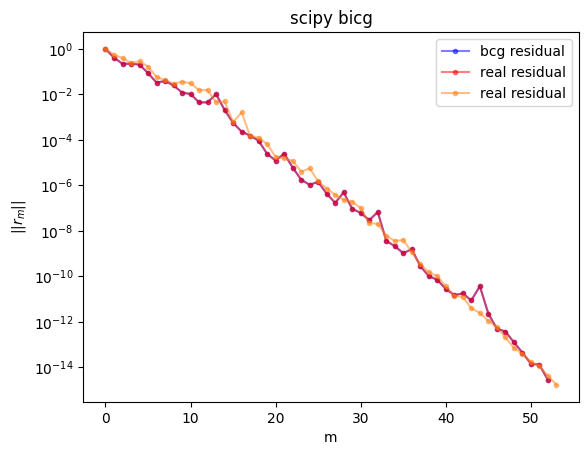

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

def bcg(A,x0,b, max_iter=10000,tol=1e-14):
    residual_norms = np.array([])
    real_residuals = np.array([])
    N = np.size(b)
    x_j   = x0
    r0    = b - A@x0
    r_j   = r0
    r_c_j = r_j
    j_max = 0
    p_j   = r_j
    p_c_j = r_c_j

    x_jp1   = 0
    p_jp1   = 0
    p_c_jp1 = 0
    r_c_jp1 = 0
    r_jp1   = 0


    for j in np.arange(0,max_iter):
        # print("||r_j||/||r_0|| = ", np.linalg.norm(r_j)/np.linalg.norm(r0))
        residual_norms = np.append(residual_norms, np.linalg.norm(r_j)/np.linalg.norm(r0))
        real_residuals = np.append(real_residuals, np.linalg.norm(b - A@x_j) / np.linalg.norm(r0))
        j_max = j
        if (np.linalg.norm(r_j) / np.linalg.norm(r0) < tol):
            break
        alpha_j = np.vdot(r_c_j, r_j)/np.vdot(p_c_j, A@p_j)
        x_jp1   = x_j   +  alpha_j*p_j
        r_jp1   = r_j   -  alpha_j*(A@p_j)
        r_c_jp1 = r_c_j -  np.conj(alpha_j) * ( (A.conj().transpose())@p_c_j )
        beta_j  = np.vdot(r_c_jp1, r_jp1) / np.vdot(r_c_j, r_j)
        p_jp1   = r_jp1   +  beta_j*p_j
        p_c_jp1 = r_c_jp1 +  np.conj(beta_j)*p_c_j

        x_j    =  x_jp1
        r_j    =  r_jp1
        r_c_j  =  r_c_jp1
        p_j    =  p_jp1
        p_c_j  =  p_c_jp1

    # print("||x_m - x*|| / ||x*|| = ", np.linalg.norm(x_j - np.linalg.solve(A,b)) / np.linalg.norm(np.linalg.solve(A,b)))
    plt.plot(np.arange(0, j_max+1), residual_norms, marker='o', markersize=3, linestyle='-', color='b', alpha=0.5, label='bcg residual')
    plt.plot(np.arange(0, j_max+1), real_residuals, marker='o', markersize=3, linestyle='-', color='r', alpha=0.5, label='real residual')


    plt.title(r'Plot of k vs $\gamma_{m+1}$ vs $m$')
    plt.xlabel('m')
    plt.ylabel(r'$\gamma_{m+1}$')
    plt.semilogy()
    plt.grid()
    plt.legend()
    # plt.show()
    

# N = 100
# A = matrix_with_singular_values(np.random.uniform(90.0, 100.0, N), N,N) + np.random.uniform(-1,1,(N,N))
# b = np.random.rand(N)
# x0 = np.zeros(N)

# bcg(A,x0,b)

N = 100
A = matrix_with_singular_values(np.random.uniform(90.0, 100.0, N), N,N) + np.random.uniform(-1,1,(N,N)) + 1.0j*np.random.uniform(-10,10,(N,N))
b = np.random.rand(N)
x0 = np.zeros(N)

bcg(A,b,x0,max_iter=500)

import scipy.sparse.linalg as scp
i = [0]
residuals = np.zeros(10000)
residuals[0] = 1.0
r0_norm = np.linalg.norm(A@x0-b)
def callback_qmr(x, i, r0_norm, residuals):
    i[0] = i[0] + 1
    residuals[i[0]]=np.linalg.norm(A@x-b)/r0_norm
scp.bicg(A,b,x0,callback= lambda x: callback_qmr(x,i,r0_norm,residuals),tol=1e-15)
plt.plot(np.arange(0, i[0]), residuals[:i[0]], marker='o', markersize=3, linestyle='-', color='tab:orange', alpha=0.5, label='real residual')
plt.title(r'scipy bicg')
plt.xlabel(r'm')
plt.ylabel(r'$||r_m||$')
plt.semilogy()
plt.grid()
plt.legend()
plt.show()

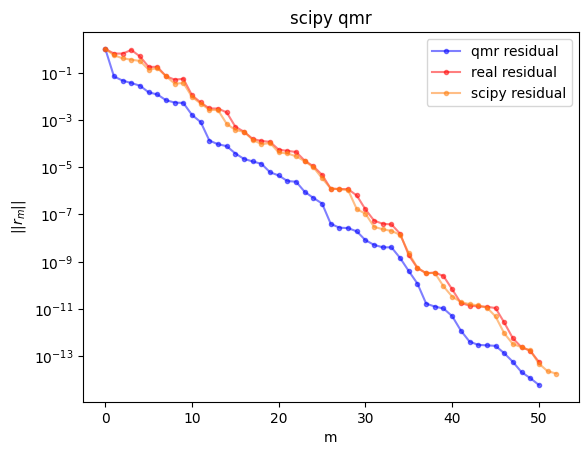

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def qmr(A, b, x0, max_iter=10000, tol=1e-6):
    N = np.size(b)
    r0 = b - A@x0
    x_mm1 = x0
    x_m = x0 
    gamma_m = np.linalg.norm(r0)
    w_mm1 = np.zeros(N)
    v_mm1 = np.zeros(N)
    v_m = r0/gamma_m
    w_m = r0/gamma_m
    beta_m = 0
    delta_m = 0

    c_mm2 = 1.0
    s_mm2 = 0.0
    c_mm1 = 1.0
    s_mm1 = 0.0

    p_mm2 = np.zeros(N)
    p_mm1 = np.zeros(N)

    g = np.array([1.0])
    real_residuals = np.array([1.0])
    mmax = 0

    for m in np.arange(1, max_iter):
        alpha_m = np.vdot(A@v_m,w_m)
        v_mp1_hat = A@v_m - alpha_m*v_m - beta_m*v_mm1
        w_mp1_hat = A.T@w_m - alpha_m*w_m - delta_m*w_mm1
        delta_mp1 = np.sqrt(np.abs(np.vdot(w_mp1_hat, v_mp1_hat)))
        if delta_mp1 < tol:
            break
        beta_mp1 = np.vdot(w_mp1_hat, v_mp1_hat) / delta_mp1
        v_mp1 = v_mp1_hat / delta_mp1
        w_mp1 = w_mp1_hat / beta_mp1

        t_m_m_mm1 = -beta_m*c_mm2*s_mm1 + alpha_m*c_mm1
        # sc_m_denom = np.sqrt( (t_m_m_mm1)**2 + (delta_mp1)**2 )
        sc_m_denom = np.sqrt( t_m_m_mm1**2 + delta_mp1**2 )
        s_m = delta_mp1 / sc_m_denom
        c_m = ( t_m_m_mm1 ) / sc_m_denom

        gamma_mp1 = -s_m*gamma_m
        g = np.append(g, np.abs(gamma_mp1)/np.linalg.norm(r0))
        gamma_m = c_m * gamma_m

        t_m_m = c_m * t_m_m_mm1 + s_m * delta_mp1
        t_mm1_m = beta_m*c_mm2*c_mm1 + alpha_m*s_mm1

        p_m = 1/t_m_m * (v_m - (beta_m*s_mm2)*p_mm2 - t_mm1_m*p_mm1)

        x_m = x_mm1 + gamma_m * p_m
        
        real_residuals = np.append(real_residuals, np.linalg.norm(b - A@x_m) / np.linalg.norm(r0))

        mmax = m
        # print(m)
        if g[-1] < tol:
            break
        
        x_mm1 = x_m
        gamma_m = gamma_mp1
        v_mm1 = v_m
        v_m = v_mp1
        w_mm1 = w_m
        w_m = w_mp1
        p_mm2 = p_mm1
        p_mm1 = p_m
        delta_m = delta_mp1
        beta_m = beta_mp1
        c_mm2 = c_mm1
        c_mm1 = c_m
        s_mm2 = s_mm1
        s_mm1 = s_m
    # print("||x_m - x*|| / ||x*|| = ", np.linalg.norm(x_m - np.linalg.solve(A,b)) / np.linalg.norm(np.linalg.solve(A,b)))
    plt.plot(np.arange(0, mmax+1), g, marker='o', markersize=3, linestyle='-', color='b', alpha=0.5, label='qmr residual')
    plt.plot(np.arange(0, mmax+1), real_residuals, marker='o', markersize=3, linestyle='-', color='r', alpha=0.5, label='real residual')
    plt.title(r'Plot of k vs $\gamma_{m+1} \;/\; ||r_0||$ vs $m$')
    plt.xlabel('m')
    plt.ylabel(r'$\gamma_{m+1} \;/\; ||r_0||$')
    plt.semilogy()
    plt.grid()
    plt.legend()
    # plt.show()

import cmath
N = 100
A = matrix_with_singular_values(np.random.uniform(90.0, 100.0, N), N,N) + np.random.uniform(-10,10,(N,N))# + 1.0j*np.random.uniform(-10,10,(N,N))
b = np.random.rand(N)
x0 = np.zeros(N)

qmr(A,b,x0,tol=1e-14)

import scipy.sparse.linalg as scp
i = [0]
residuals = np.zeros(10000)
residuals[0] = 1.0
r0_norm = np.linalg.norm(A@x0-b)
def callback_qmr(x, i, r0_norm, residuals):
    i[0] = i[0] + 1
    residuals[i[0]]=np.linalg.norm(A@x-b)/r0_norm
scp.qmr(A,b,x0,callback= lambda x: callback_qmr(x,i,r0_norm,residuals),tol=1e-14)
plt.plot(np.arange(0, i[0]), residuals[:i[0]], marker='o', markersize=3, linestyle='-', color='tab:orange', alpha=0.5, label='scipy residual')
plt.title(r'scipy qmr')
plt.xlabel('m')
plt.ylabel(r'$||r_m||$')
plt.semilogy()
plt.grid()
plt.legend()
plt.show()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


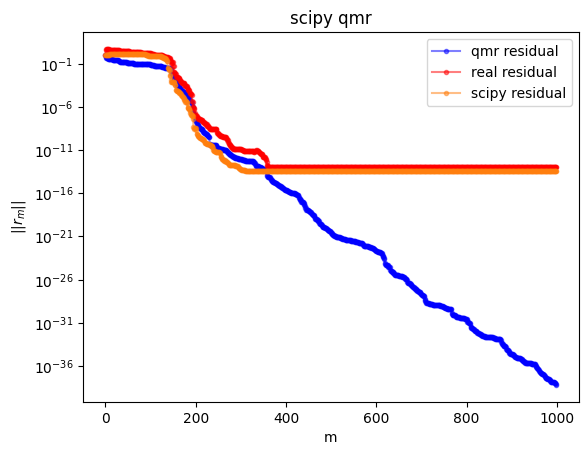

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def cqmr(A, b, x0, max_iter=10000, tol=1e-6):
    N = np.size(b)
    r0 = b - A@x0
    
    x_mm1 = x0
    x_m = x0 
    gamma_m = np.linalg.norm(r0)
    w_mm1 = np.zeros(N)
    v_mm1 = np.zeros(N)
    v_m = r0/gamma_m
    w_m = r0/gamma_m
    beta_m = 0
    delta_m = 0

    c_mm2 = 1.0
    s_mm2 = 0.0
    c_mm1 = 1.0
    s_mm1 = 0.0

    p_mm2 = np.zeros(N)
    p_mm1 = np.zeros(N)

    g = np.array([1.0])
    real_residuals = np.array([1.0])
    mmax = 0

    for m in np.arange(1, max_iter):
        alpha_m = np.vdot(w_m,A@v_m)
        v_mp1_hat = A@v_m - alpha_m*v_m - beta_m*v_mm1
        w_mp1_hat = A.conj().T@w_m - np.conj(alpha_m)*w_m - np.conj(delta_m)*w_mm1
        delta_mp1 = np.sqrt(np.abs(np.vdot(w_mp1_hat, v_mp1_hat)))
        if np.abs(delta_mp1) < tol:
            break
        beta_mp1 = np.vdot(w_mp1_hat, v_mp1_hat) / delta_mp1
        v_mp1 = v_mp1_hat / delta_mp1
        w_mp1 = w_mp1_hat / np.conj(beta_mp1)
        
        t_m_m_mm1 = -beta_m*np.conj(c_mm2)*np.conj(s_mm1) + alpha_m*np.conj(c_mm1)
        # sc_m_denom = np.sqrt( (t_m_m_mm1)**2 + (delta_mp1)**2 )
        sc_m_denom = np.sqrt( np.abs(t_m_m_mm1)**2 + np.abs(delta_mp1)**2 )
        s_m = np.conj(delta_mp1) / sc_m_denom
        c_m = np.conj(t_m_m_mm1) / sc_m_denom

        gamma_mp1 = -np.conj(s_m)*gamma_m
        g = np.append(g, np.abs(gamma_mp1)/np.linalg.norm(r0))
        gamma_m = c_m * gamma_m

        # print(np.abs(-np.conj(s_m)*t_m_m_mm1 + np.conj(c_m)*delta_mp1))

        t_m_m = c_m * t_m_m_mm1 + s_m * delta_mp1
        t_mm1_m = beta_m*np.conj(c_mm2)*c_mm1 + alpha_m*s_mm1

        p_m = 1/t_m_m * (v_m - (beta_m*s_mm2)*p_mm2 - t_mm1_m*p_mm1)

        x_m = x_mm1 + gamma_m * p_m
        
        real_residuals = np.append(real_residuals, np.linalg.norm(b - A@x_m) / np.linalg.norm(r0))

        mmax = m
        print(m)
        # if g[-1] < tol:
        if real_residuals[-1] < tol:
            break
        
        x_mm1 = x_m
        gamma_m = gamma_mp1
        v_mm1 = v_m
        v_m = v_mp1
        w_mm1 = w_m
        w_m = w_mp1
        p_mm2 = p_mm1
        p_mm1 = p_m
        delta_m = delta_mp1
        beta_m = beta_mp1
        c_mm2 = c_mm1
        c_mm1 = c_m
        s_mm2 = s_mm1
        s_mm1 = s_m
    # print("||x_m - x*|| / ||x*|| = ", np.linalg.norm(x_m - np.linalg.solve(A,b)) / np.linalg.norm(np.linalg.solve(A,b)))
    plt.plot(np.arange(0, mmax+1), g, marker='o', markersize=3, linestyle='-', color='b', alpha=0.5, label='qmr residual')
    plt.plot(np.arange(0, mmax+1), real_residuals, marker='o', markersize=3, linestyle='-', color='r', alpha=0.5, label='real residual')
    plt.title(r'Plot of k vs $\gamma_{m+1} \;/\; ||r_0||$ vs $m$')
    plt.xlabel('m')
    plt.ylabel(r'$\gamma_{m+1} \;/\; ||r_0||$')
    plt.semilogy()
    plt.grid()
    plt.legend()
    # plt.show()

import cmath
N = 100
A = matrix_with_singular_values(np.random.uniform(90.0, 100.0, N), N,N) + np.random.uniform(-10,10,(N,N)) + 10.0j*np.random.uniform(-10,10,(N,N))
b = np.random.rand(N)
x0 = np.zeros(N)


import scipy.sparse.linalg as scp
i = [0]
residuals = np.zeros(10000)
residuals[0] = 1.0
r0_norm = np.linalg.norm(A@x0-b)
def callback_qmr(x, i, r0_norm, residuals):
    i[0] = i[0] + 1
    residuals[i[0]]=np.linalg.norm(A@x-b)/r0_norm
scp.qmr(A,b,x0,callback= lambda x: callback_qmr(x,i,r0_norm,residuals),tol=1e-14)
cqmr(A,b,x0,tol=1e-14, max_iter=i[0])
plt.plot(np.arange(0, i[0]), residuals[:i[0]], marker='o', markersize=3, linestyle='-', color='tab:orange', alpha=0.5, label='scipy residual')
plt.title(r'scipy qmr')
plt.xlabel('m')
plt.ylabel(r'$||r_m||$')
plt.semilogy()
plt.grid()
plt.legend()
plt.show()

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def quasi_gs(A, V, dtype = np.complex128):
    m = np.shape(V)[0]
    n = np.shape(V)[1]
    Q = np.zeros((m,n), dtype=dtype)
    R = np.zeros((n,n), dtype=dtype)
    for i in range(n):
        tilde_q_i = V[:,i]
        for k in range(i):
            R[k,i] = np.inner(V[:,i], A@Q[:,k])
            tilde_q_i -= Q[:,k] * R[k,i]
        R[i,i] = np.sqrt(np.inner(tilde_q_i, A@tilde_q_i))
        Q[:,i] = tilde_q_i / R[i,i]
    return Q, R

def block_symmetric_qmr(A, b, x0, max_iter=10000, tol=1e-6):
    N           = np.shape(b)[0]
    s           = np.shape(b)[1]
    x_mm1       = x0
    v_mm1       = np.zeros((N,s))
    p_mm1       = np.zeros((N,s))
    p_mm2       = np.zeros((N,s))

    c_mm1       = np.zeros((s,s))
    b_mm2       = np.zeros((s,s))
    b_mm1       = np.zeros((s,s))

    a_mm1       = np.identity(s)
    d_mm2       = np.identity(s)
    d_mm1       = np.identity(s)

    tilde_v_m   = b - A@x0
    v_m, beta_m = quasi_gs(A, tilde_v_m) # in complex case quasi-qr needed
    omega_m     = np.diag([np.linalg.norm(v_m[:,i]) for i in range(s)])
    tilde_tau_m = omega_m @ beta_m
    omega_mm1   = np.diag([np.linalg.norm(v_mm1[:,i]) for i in range(s)])

    initial_residual = np.max([np.linalg.norm(tilde_v_m[:,i]) for i in range(s)])
    real_residuals = np.array([1.0])

    for k in range(max_iter):
        tilde_v_mp1 = A@v_m - v_mm1@beta_m.T
        alpha_m = v_m.T@tilde_v_mp1
        tilde_v_mp1 = tilde_v_mp1 - v_m @ alpha_m
        v_mp1,beta_mp1 = quasi_gs(A, tilde_v_mp1)
        omega_mp1 = np.diag([np.linalg.norm(v_mp1[:,i]) for i in range(s)])
        theta_m = b_mm2 @ omega_mm1 @ beta_m.T
        eta_m =        a_mm1 @ d_mm2 @ omega_mm1 @ beta_m.T + b_mm1 @ omega_m @ alpha_m
        tilde_zeta_m = c_mm1 @ d_mm2 @ omega_mm1 @ beta_m.T + d_mm1 @ omega_m @ alpha_m
        tmp = np.vstack((tilde_zeta_m, omega_mp1@beta_mp1))
        Q,R = np.linalg.qr(tmp, mode='complete')
        Q_tmp = np.conj(Q.T)
        Q = Q_tmp
       
        a_m = Q[:s,:s]
        b_m = Q[:s,s:]
        c_m = Q[s:,:s]
        d_m = Q[s:,s:]
        zeta_m = R[:s, :]
        # if (k==1):
            # print(Q@np.conj(Q).T)
            # print(R)
            # print ("")
            # print(a_m, b_m, c_m, d_m, zeta_m)
        p_m = (v_m - p_mm1 @ eta_m - p_mm2 @ theta_m) @ np.linalg.inv(zeta_m)
        tau_m = a_m @ tilde_tau_m
        x_m = x_mm1 + p_m @ tau_m
        tilde_tau_mp1 = c_m @ tilde_tau_m

        real_residuals_block = b - A @ x_m 
        real_residuals_norms = np.zeros(s)
        for i in range(s):
            real_residuals_norms[i] = np.linalg.norm(real_residuals_block[:,i])  
        real_residuals = np.append(real_residuals, np.max(real_residuals_norms)/ initial_residual)
        print(real_residuals[-1])
        if (real_residuals[-1] < tol):
            break

        x_mm1 = x_m
        p_mm2 = p_mm1
        p_mm1 = p_m
        c_mm1 = c_m
        b_mm2 = b_mm1
        b_mm1 = b_m
        a_mm1 = a_m
        d_mm2 = d_mm1
        d_mm1 = d_m
        beta_m = beta_mp1
        v_mm1 = v_m
        v_m = v_mp1
        omega_mm1 = omega_m
        omega_m = omega_mp1
        tilde_tau_m = tilde_tau_mp1
    return real_residuals
        


In [255]:
# test of quasi_gs()

# matrix = np.array([[1,       1.0j, 1.0 + 1.0j],
#                    [2 + 3.0j,   4,          5],
#                    [7,          8,     9 +10j]])
matrix = np.random.rand(4,4) + 1.0j*np.random.rand(4,4)
A = np.identity(4)*2
A[1,2] = 10
A[2,1] = 10
Q,R = quasi_gs(A,matrix,dtype=type(matrix[0,0]))
real_Q, real_R = np.linalg.qr(matrix)

print(np.dot(np.conj(real_Q).T,real_Q))
print(" ")
np.set_printoptions(formatter={'float_kind': '{:.2f}'.format})
np.set_printoptions(formatter={'complex_kind': '{:.2f}'.format})
print(np.dot((A@Q).T,Q))
print(" ")
print(R)
print(" ")
print(Q)
print(" ")
print(Q[2:, :2])
omega_mp1 = np.diag([np.linalg.norm(A[:,i]) for i in range(4)])
print(omega_mp1)

[[1.00+0.00j 0.00+0.00j 0.00+0.00j -0.00+0.00j]
 [0.00+0.00j 1.00+0.00j 0.00-0.00j -0.00-0.00j]
 [0.00-0.00j 0.00+0.00j 1.00+0.00j 0.00-0.00j]
 [-0.00-0.00j -0.00+0.00j 0.00+0.00j 1.00+0.00j]]
 
[[1.00-0.00j 0.00-0.00j 0.00+0.00j -0.00-0.00j]
 [0.00-0.00j 1.00+0.00j 0.00+0.00j -0.00+0.00j]
 [0.00+0.00j 0.00+0.00j 1.00+0.00j -0.00-0.00j]
 [-0.00-0.00j -0.00+0.00j -0.00-0.00j 1.00-0.00j]]
 
[[2.76+3.70j 0.97+1.42j 4.74+3.05j 0.63+2.10j]
 [0.00+0.00j 0.29-0.82j 1.40-1.72j 0.19-1.14j]
 [0.00+0.00j 0.00+0.00j 0.68+1.77j 1.29+0.44j]
 [0.00+0.00j 0.00+0.00j 0.00+0.00j 0.05+0.76j]]
 
[[0.21-0.07j -0.69+0.08j -0.25-0.36j -0.26+0.07j]
 [0.29-0.04j 0.25-0.23j 0.19+0.38j -0.00-0.05j]
 [0.12+0.04j -0.06+0.04j 0.01-0.19j -0.03+0.02j]
 [0.12-0.05j -0.26+0.03j -0.01-0.07j 0.65+0.02j]]
 
[[0.12+0.04j -0.06+0.04j]
 [0.12-0.05j -0.26+0.03j]]
[[ 2.          0.          0.          0.        ]
 [ 0.         10.19803903  0.          0.        ]
 [ 0.          0.         10.19803903  0.        ]
 [ 0.       

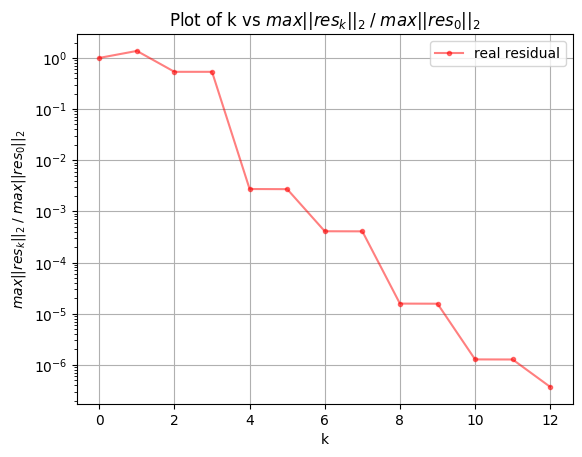

In [320]:
# test of block_symmetric_qmr()

N = 10
s = 6
A = matrix_with_singular_values(np.random.uniform(90.0, 100.0, N), N,N) + 1.0j*np.random.uniform(-10,10,(N,N))
A_tmp = A + A.T
A = A_tmp
b = np.random.rand(N, s) + 0.0j
x0 = np.zeros((N,s)) + 0.0j
residuals = block_symmetric_qmr(A, b, x0,tol=1e-6)

import matplotlib.pyplot as plt
plt.plot(range(np.size(residuals)), residuals, marker='o', markersize=3, linestyle='-', color='r', alpha=0.5, label='real residual') 
plt.title(r'Plot of k vs $max||res_k||_2 \;/\; max||res_0||_2$')
plt.xlabel('k')
plt.ylabel(r'$max||res_k||_2 \;/\; max||res_0||_2$')
plt.semilogy()
plt.grid()
plt.legend()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
||x_m - x*|| / ||x*|| =  2.8987214379983034e-14


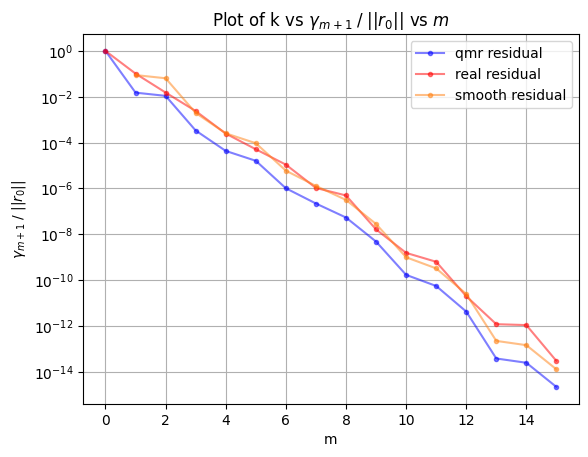

1 0.10173234482048248
2 0.01259795160644791
3 0.0015852629283996792


(array([ 1.01278740e-02, -1.57540642e-05,  3.25814244e-03,  1.50871975e-03,
         7.70895010e-04,  3.05609739e-03,  1.78265187e-03,  1.81812047e-03,
         5.05448553e-03,  6.05338506e-03,  9.80167288e-03,  6.52129371e-03,
         3.22263986e-03,  9.50962279e-03,  4.55873340e-03, -1.51414237e-04,
         3.60767325e-03,  9.07672118e-03,  9.04381163e-03,  7.73826810e-03,
         9.47495858e-03,  5.57605520e-03,  8.31781937e-03,  6.57874252e-03,
         1.55962710e-03,  8.01394783e-03,  1.61727645e-03,  7.58588571e-03,
         2.60253558e-03,  8.32486558e-03,  7.45103284e-03,  6.71062718e-03,
         8.25341265e-03,  6.94440499e-03,  7.86546026e-03,  4.15338861e-03,
         5.18471890e-03,  1.27677543e-03,  5.80663064e-03,  3.65303555e-03,
         1.01198372e-02,  7.11486482e-03,  8.62008593e-03,  9.66508010e-04,
         5.34612024e-03,  5.56917435e-03,  6.21905979e-03,  2.03070783e-03,
         3.64116491e-03,  4.68851305e-03,  1.02307270e-02,  2.21379873e-03,
         3.3

In [95]:
import numpy as np
import matplotlib.pyplot as plt

def qmr_smoothing(A, b, x0, max_iter=10000, tol=1e-6):
    N = np.size(b)
    r0 = b - A@x0
    rho_mm1_Q = np.linalg.norm(r0)
    x_mm1 = x0
    x_mm1_Q = x0
    x_m = x0 
    gamma_m = np.linalg.norm(r0)
    w_mm1 = np.zeros(N)
    v_mm1 = np.zeros(N)
    v_m = r0/gamma_m
    w_m = r0/gamma_m
    beta_m = 0
    delta_m = 0

    c_mm2 = 1.0
    s_mm2 = 0.0
    c_mm1 = 1.0
    s_mm1 = 0.0

    p_mm2 = np.zeros(N)
    p_mm1 = np.zeros(N)

    g = np.array([1.0])
    real_residuals = np.array([1.0])
    smooth_residuals = np.array([])
    mmax = 0

    for m in np.arange(1, N):
        alpha_m = np.dot(A@v_m,w_m)
        v_mp1_hat = A@v_m - alpha_m*v_m - beta_m*v_mm1
        w_mp1_hat = A.conj().T@w_m - alpha_m*w_m - delta_m*w_mm1
        delta_mp1 = np.sqrt(np.abs(np.dot(v_mp1_hat,w_mp1_hat)))
        if delta_mp1 < tol:
            break
        beta_mp1 = np.dot(v_mp1_hat,w_mp1_hat) / delta_mp1
        v_mp1 = v_mp1_hat / delta_mp1
        w_mp1 = w_mp1_hat / beta_mp1

        t_m_m_mm1 = -beta_m*c_mm2*s_mm1 + alpha_m*c_mm1
        sc_m_denom = np.sqrt( (t_m_m_mm1)**2 + (delta_mp1)**2 )
        s_m = delta_mp1 / sc_m_denom
        c_m = ( t_m_m_mm1 ) / sc_m_denom

        gamma_mp1 = -s_m*gamma_m
        g = np.append(g, np.abs(gamma_mp1)/np.linalg.norm(r0))
        gamma_m = c_m * gamma_m

        t_m_m = c_m * t_m_m_mm1 + s_m * delta_mp1
        t_mm1_m = beta_m*c_mm2*c_mm1 + alpha_m*s_mm1

        p_m = 1/t_m_m * (v_m - (beta_m*s_mm2)*p_mm2 - t_mm1_m*p_mm1)

        x_m = x_mm1 + gamma_m * p_m
        
        rho_m_Q = 1 / np.sqrt((1/rho_mm1_Q)**2 + (1/gamma_mp1)**2)

        smooth_residuals = np.append(smooth_residuals, rho_m_Q)

        eta_m = (rho_m_Q / gamma_mp1)**2
        x_m_Q = x_mm1_Q + eta_m*(x_m - x_mm1_Q)

        real_residuals = np.append(real_residuals, np.linalg.norm(b - A@x_m_Q) / np.linalg.norm(r0))
        
        mmax = m
        print(m)
        if g[-1] < tol:
            break
        
        x_mm1 = x_m
        gamma_m = gamma_mp1
        v_mm1 = v_m
        v_m = v_mp1
        w_mm1 = w_m
        w_m = w_mp1
        p_mm2 = p_mm1
        p_mm1 = p_m
        delta_m = delta_mp1
        beta_m = beta_mp1
        c_mm2 = c_mm1
        c_mm1 = c_m
        s_mm2 = s_mm1
        s_mm1 = s_m
        
    print("||x_m - x*|| / ||x*|| = ", np.linalg.norm(x_m - np.linalg.solve(A,b)) / np.linalg.norm(np.linalg.solve(A,b)))
    plt.plot(np.arange(0, mmax+1), g, marker='o', markersize=3, linestyle='-', color='b', alpha=0.5, label='qmr residual')
    plt.plot(np.arange(0, mmax+1), real_residuals, marker='o', markersize=3, linestyle='-', color='r', alpha=0.5, label='real residual')
    plt.plot(np.arange(1, mmax+1), smooth_residuals, marker='o', markersize=3, linestyle='-', color='tab:orange', alpha=0.5, label='smooth residual')
    plt.title(r'Plot of k vs $\gamma_{m+1} \;/\; ||r_0||$ vs $m$')
    plt.xlabel('m')
    plt.ylabel(r'$\gamma_{m+1} \;/\; ||r_0||$')
    plt.semilogy()
    plt.grid()
    plt.legend()
    plt.show()

    
N = 100
A = matrix_with_singular_values(np.random.uniform(90.0, 100.0, N), N,N) + np.random.uniform(-2,2,(N,N))
b = np.random.rand(N)
x0 = np.zeros(N)
qmr_smoothing(A, b, x0,tol=1e-14)

import scipy.sparse.linalg  

x0 = np.zeros(np.shape(b)[0])
i = [0]
def print_residual(x, i):
    i[0] = i[0] + 1
    print(i[0], x)
    
scipy.sparse.linalg.gmres(A,b, tol=1e-2, callback_type='pr_norm', callback = lambda x: print_residual(x, i))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def max_norm(b):
    m = np.shape(b)[1]
    norms = np.zeros(m)
    for i in range(m):
        norms[i] = np.linalg.norm(b[:,i])
    return np.max(norms)

def bqmr(A, b, x0, max_iter=10000, tol=1e-6):
    N, m = np.shape(b)
    r0 = b - A@x0
    x_mm1 = x0
    x_m = x0 
    gamma_m = max_norm(r0)
    w_mm1 = np.zeros((N,m))
    v_mm1 = np.zeros((N,m))
    v_m = r0/gamma_m
    w_m = r0/gamma_m
    beta_m = 0
    delta_m = 0

    c_mm2 = 1.0
    s_mm2 = 0.0
    c_mm1 = 1.0
    s_mm1 = 0.0

    p_mm2 = np.zeros(N)
    p_mm1 = np.zeros(N)

    g = np.array([1.0])
    real_residuals = np.array([1.0])
    mmax = 0

    for m in np.arange(1, max_iter):
        alpha_m = np.vdot(A@v_m,w_m)
        v_mp1_hat = A@v_m - alpha_m*v_m - beta_m*v_mm1
        w_mp1_hat = A.T@w_m - alpha_m*w_m - delta_m*w_mm1
        delta_mp1 = np.sqrt(np.abs(np.vdot(w_mp1_hat, v_mp1_hat)))
        if delta_mp1 < tol:
            break
        beta_mp1 = np.vdot(w_mp1_hat, v_mp1_hat) / delta_mp1
        v_mp1 = v_mp1_hat / delta_mp1
        w_mp1 = w_mp1_hat / beta_mp1

        t_m_m_mm1 = -beta_m*c_mm2*s_mm1 + alpha_m*c_mm1
        # sc_m_denom = np.sqrt( (t_m_m_mm1)**2 + (delta_mp1)**2 )
        sc_m_denom = np.sqrt( t_m_m_mm1**2 + delta_mp1**2 )
        s_m = delta_mp1 / sc_m_denom
        c_m = ( t_m_m_mm1 ) / sc_m_denom

        gamma_mp1 = -s_m*gamma_m
        g = np.append(g, np.abs(gamma_mp1)/np.linalg.norm(r0))
        gamma_m = c_m * gamma_m

        t_m_m = c_m * t_m_m_mm1 + s_m * delta_mp1
        t_mm1_m = beta_m*c_mm2*c_mm1 + alpha_m*s_mm1

        p_m = 1/t_m_m * (v_m - (beta_m*s_mm2)*p_mm2 - t_mm1_m*p_mm1)

        x_m = x_mm1 + gamma_m * p_m
        
        real_residuals = np.append(real_residuals, np.linalg.norm(b - A@x_m) / np.linalg.norm(r0))

        mmax = m
        # print(m)
        if g[-1] < tol:
            break
        
        x_mm1 = x_m
        gamma_m = gamma_mp1
        v_mm1 = v_m
        v_m = v_mp1
        w_mm1 = w_m
        w_m = w_mp1
        p_mm2 = p_mm1
        p_mm1 = p_m
        delta_m = delta_mp1
        beta_m = beta_mp1
        c_mm2 = c_mm1
        c_mm1 = c_m
        s_mm2 = s_mm1
        s_mm1 = s_m
    # print("||x_m - x*|| / ||x*|| = ", np.linalg.norm(x_m - np.linalg.solve(A,b)) / np.linalg.norm(np.linalg.solve(A,b)))
    plt.plot(np.arange(0, mmax+1), g, marker='o', markersize=3, linestyle='-', color='b', alpha=0.5, label='qmr residual')
    plt.plot(np.arange(0, mmax+1), real_residuals, marker='o', markersize=3, linestyle='-', color='r', alpha=0.5, label='real residual')
    plt.title(r'Plot of k vs $\gamma_{m+1} \;/\; ||r_0||$ vs $m$')
    plt.xlabel('m')
    plt.ylabel(r'$\gamma_{m+1} \;/\; ||r_0||$')
    plt.semilogy()
    plt.grid()
    plt.legend()
    # plt.show()

import cmath
N = 100
A = matrix_with_singular_values(np.random.uniform(90.0, 100.0, N), N,N) + np.random.uniform(-10,10,(N,N))# + 1.0j*np.random.uniform(-10,10,(N,N))
b = np.random.rand(N)
x0 = np.zeros(N)

qmr(A,b,x0,tol=1e-14)

import scipy.sparse.linalg as scp
i = [0]
residuals = np.zeros(10000)
residuals[0] = 1.0
r0_norm = np.linalg.norm(A@x0-b)
def callback_qmr(x, i, r0_norm, residuals):
    i[0] = i[0] + 1
    residuals[i[0]]=np.linalg.norm(A@x-b)/r0_norm
scp.qmr(A,b,x0,callback= lambda x: callback_qmr(x,i,r0_norm,residuals),tol=1e-14)
plt.plot(np.arange(0, i[0]), residuals[:i[0]], marker='o', markersize=3, linestyle='-', color='tab:orange', alpha=0.5, label='scipy residual')
plt.title(r'scipy qmr')
plt.xlabel('m')
plt.ylabel(r'$||r_m||$')
plt.semilogy()
plt.grid()
plt.legend()
plt.show()

In [1]:
import struct
import numpy as np

def read_complex_matrix_binary(file_path):
    with open(file_path, 'rb') as f:
        # Read rows and cols (as 4-byte integers)
        rows, cols = struct.unpack('ii', f.read(8))
        
        # Read all remaining bytes (complex numbers)
        buffer = f.read()
        
        # Calculate number of complex numbers
        num_complex = len(buffer) // 8  # 16 bytes per complex (2 doubles)
        if num_complex != rows * cols:
            raise ValueError("Data length mismatch")
        
        # Unpack into list of complex numbers
        complex_data = [
            complex(*struct.unpack('ff', buffer[i*8:(i+1)*8])) 
            for i in range(num_complex)
        ]
        
        # # Reshape into matrix
        # matrix = [
        #     complex_data[i*cols : (i+1)*cols] 
        #     for i in range(rows)
        # ]
        matrix = np.array(complex_data, dtype = np.complex64)
        matrix = np.reshape(matrix, (cols, rows)).transpose()
    return matrix

# Example usage
matrix = read_complex_matrix_binary("/home/starman/mat_alm_full.dat")
# print(matrix)

In [11]:
matrix_tmp = matrix + matrix.T

In [15]:
matrix = matrix_tmp/2

In [2]:
rhs = read_complex_matrix_binary("/home/starman/rhs_alm_722.dat")

In [5]:
type(matrix[0,0])
np.shape(rhs)
print(matrix[-1, -1], matrix[0, 1], matrix[2, 0])
print(rhs[0, 0], rhs[1, 0])
print(np.linalg.norm(matrix))
print(np.linalg.norm(rhs[:, 0]))

(-5382.583+32.797604j) (-2475.4912-17.7401j) (-474.9421+20.280767j)
(-0.0010527076+0.0021956586j) (-0.00086139695+0.0009309049j)
1077516.2
0.279832


In [ ]:
x0 = np.zeros((np.shape(rhs)[0], 5))
b = rhs[:,[180, 204, 155, 229, 130]]

residuals = block_symmetric_qmr(matrix, b, x0, max_iter=200,tol=0.01)
# scp.qmr(matrix,b,x0,callback= lambda x: callback_qmr(x,i,r0_norm,residuals),tol=1e-2)
plt.plot(range(np.size(residuals)), residuals, marker='o', markersize=3, linestyle='-', color='tab:orange', alpha=0.5, label='scipy residual')
plt.title(r'bsqmr')
plt.xlabel('k')
plt.ylabel(r'$max||r_k||;/;max||r_0||$')
plt.semilogy()
plt.grid()
plt.legend()
plt.show()

0.38224709291395453
0.3507156608475988
0.3507027268546052
0.3516503404603989
0.35165210127534546
0.30710814336037345
0.30711237965405186
0.2519502838050599
0.251948798033243
0.24686445601066379
0.2468634945974864
0.22895447437281768
0.22895212489830685
0.2367886008690842
0.2367830411983462
0.18044556899181063
0.18044519339032744


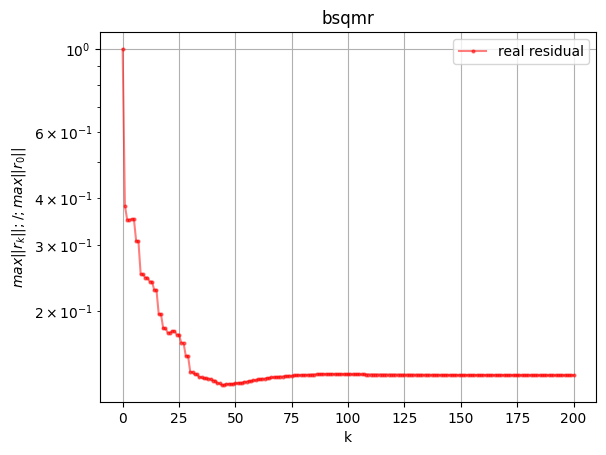

In [10]:
plt.plot(range(np.size(residuals)), residuals, marker='o', markersize=2, linestyle='-', color='r', alpha=0.5, label='real residual')
plt.title(r'bsqmr')
plt.xlabel('k')
plt.ylabel(r'$max||r_k||;/;max||r_0||$')
plt.semilogy()
plt.grid()
plt.legend()
plt.show()

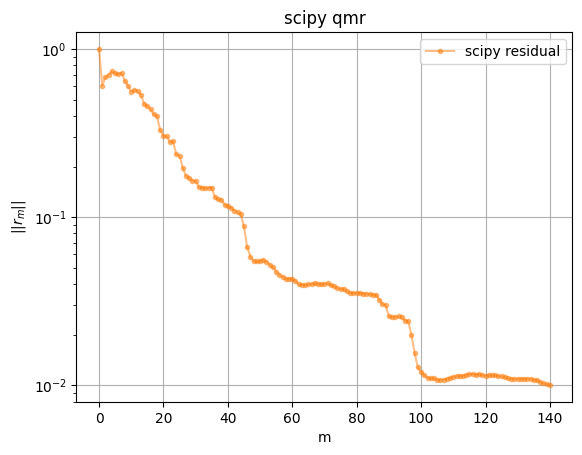

In [12]:
x0 = np.zeros(np.shape(rhs)[0])
b = rhs[:,0]

import scipy.sparse.linalg as scp
i = [0]
residuals = np.zeros(10000)
residuals[0] = 1.0
r0_norm = np.linalg.norm(matrix@x0-b)
def callback_qmr(x, i, r0_norm, residuals):
    i[0] = i[0] + 1
    residuals[i[0]]=np.linalg.norm(matrix@x-b)/r0_norm
scp.qmr(matrix,b,x0,callback= lambda x: callback_qmr(x,i,r0_norm,residuals),tol=1e-2)
plt.plot(np.arange(0, i[0]), residuals[:i[0]], marker='o', markersize=3, linestyle='-', color='tab:orange', alpha=0.5, label='scipy residual')
plt.title(r'scipy qmr')
plt.xlabel('m')
plt.ylabel(r'$||r_m||$')
plt.semilogy()
plt.grid()
plt.legend()
plt.show()

In [ ]:
import scipy.sparse.linalg  

x0 = np.zeros(np.shape(rhs)[0])
b = rhs[:,0]
i = [0]
def print_residual(x, i):
    i[0] = i[0] + 1
    print(i[0], x)#np.linalg.norm(matrix @ x - b) / np.linalg.norm(b))
    
scipy.sparse.linalg.gmres(matrix,b, tol=1e-2, callback_type='pr_norm', callback = lambda x: print_residual(x, i))

1 0.6057835346410775
2 0.5075040438340105
3 0.4585197096703972
4 0.42549142647549354
5 0.3915919936559625
6 0.36428115072797534
7 0.3429060480079884
8 0.3128918163108902
9 0.2931664104258284
10 0.2759987801402487
11 0.25912711547792644
12 0.24432846156238325
13 0.2280238335929822
14 0.21490388465796853
15 0.20076589491953015
16 0.18706756696022536
17 0.17552834230282768
18 0.16526017763901438
19 0.15217397613360478
20 0.14576529265770952
21 0.14238814011751721
22 0.13378924180402071
23 0.1288645799119963
24 0.12238076014707329
25 0.11673733791116217
26 0.11127729002202862
27 0.10500733710388638
28 0.10057259203902529
29 0.09540954149930071
30 0.09058869122702086
31 0.08619695250193725
32 0.08224971468445315
33 0.07647231448738413
34 0.07298955312705413
35 0.0685498757455586
36 0.06519739144483623
37 0.06172711064279175
38 0.057051207910365546
39 0.05414336762764436
40 0.05111515485637094
41 0.049806699782014234
42 0.04790142441044372
43 0.04551520157293108
44 0.043787090222335255
45 0.

(array([ 8.0801051e-08+1.07349365e-07j,  2.6938835e-07+3.68778075e-07j,
         2.2068914e-08+1.32223789e-07j, ...,
         7.3417581e-08+1.44395756e-07j, -1.2697173e-07-1.01544863e-07j,
        -1.5262287e-07-4.15611972e-08j], dtype=complex64),
 0)

In [ ]:
import scipy.sparse.linalg  

x0 = np.zeros(np.shape(rhs)[0])
b = rhs[:,0]
i = [0]
x_exact = [np.linalg.solve(matrix, b)]
def x_error(x, i, x_exact):
    i[0] = i[0] + 1
    print(i[0], np.linalg.norm(x - x_exact[0]) / np.linalg.norm(x_exact[0]))
    
scipy.sparse.linalg.bicg(matrix,b,tol=1e-2, callback = lambda x: x_error(x, i, x_exact))


1 0.96238345
2 0.99664855
3 0.986749
4 0.9909195
5 0.9372455
6 0.8699777
7 0.8671866
8 0.7056992
9 0.64027554
10 0.5652738
11 0.55783063
12 0.5509857
13 0.5261401
14 0.46911186
15 0.45561972
16 0.43174836
17 0.40505978
18 0.39583907
19 0.3454236
20 0.33281714
21 0.33261624
22 0.31535646
23 0.31492653
24 0.28559232
25 0.28056598
26 0.25919884
27 0.24944367
28 0.24387
29 0.23841085
30 0.2387218
31 0.22738077
32 0.22385268
33 0.22104393
34 0.22161229
35 0.22210303
36 0.20152903
37 0.19406518
38 0.1896532
39 0.1841115
40 0.18422571
41 0.18173087
42 0.18088707
43 0.17972119
44 0.17768466
45 0.16496234
46 0.15025751
47 0.14482336
48 0.14281587
49 0.14202939
50 0.14190926
51 0.14244846
52 0.14151439
53 0.14044903
54 0.13942106
55 0.13880302
56 0.13888481
57 0.13889772
58 0.14000379
59 0.14043008
60 0.14150764
61 0.14146389
62 0.13989264
63 0.14018005
64 0.14159755
65 0.14331955
66 0.14423473
67 0.14514956
68 0.14534989
69 0.145202
70 0.14561452
71 0.14609115
72 0.14378445
73 0.14191347
74 0.1

(array([ 7.9680113e-08+8.30316722e-08j,  2.5953992e-07+3.47512469e-07j,
         3.3866932e-08+1.12978235e-07j, ...,
         7.6438262e-08+1.44541787e-07j, -1.3436899e-07-9.82442074e-08j,
        -1.6104943e-07-3.56691316e-08j], dtype=complex64),
 0)